In [1]:
# Title: User Activity Analysis
# Author: Shery Cheong
# Description: Understand the monthly volume of customer churn, increase customer retention.
# Date: 03/22/21
# Version: 1.0

######################################################################################################################################################
##### Housekeeping #####
######################################################################################################################################################

# Import all needed packages
import csv
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

# Suppress scientific notation
pd.options.display.float_format = '{:.2f}'.format

print ("Imported libraries - success")

Imported libraries - success


In [2]:
######################################################################################################################################################
##### Data Cleaning #####
######################################################################################################################################################

# Read in csv input
df = pd.read_csv('user_activity_log.csv')
print ('Dataframe head')
display (df.head())
print('\n')

# Check column types
print ('Dataframe column types')
print (df.info())
print('\n')

# Check for null/missing values
print ('Dataframe missing values')
print (df.isnull().sum(axis = 0))
print('\n')

# Replace missing values with zero. 
# Since we are not doing trend analysis but instead modelling at the user level, it should be fine to assume zero if missing.
df = df.fillna(0)

Dataframe head


,monthly_spend_sum,ticket_creation_cnt,referral_cnt,product_a_cnt,product_b_cnt,website_bug_cnt,billing_segment_id,uuid
0,808.87,0.00,0.00,0.00,0.00,5.00,80.00,7a3febe0-3fcc-3a28-bdab-c29438888d12
1,584.00,0.00,0.00,0.00,0.00,8.00,81.00,7a3febe0-3fcc-3a28-bdab-c29438888d12
2,831.12,0.00,0.00,0.00,0.00,14.00,82.00,7a3febe0-3fcc-3a28-bdab-c29438888d12
3,1056.12,0.00,0.00,0.00,0.00,161.00,83.00,7a3febe0-3fcc-3a28-bdab-c29438888d12
4,2.38,0.00,0.00,0.00,0.00,15.00,84.00,7a3febe0-3fcc-3a28-bdab-c29438888d12




Dataframe column types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902105 entries, 0 to 1902104
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   monthly_spend_sum    float64
 1   ticket_creation_cnt  float64
 2   referral_cnt         float64
 3   product_a_cnt        float64
 4   product_b_cnt        float64
 5   website_bug_cnt      float64
 6   billing_segment_id   float64
 7   uuid                 object 
dtypes: float64(7), object(1)
memory usage: 116.1+ MB
None


Dataframe missing values
monthly_spend_sum      2
ticket_creation_cnt    2
referral_cnt           2
product_a_cnt          2
product_b_cnt          2
website_bug_cnt        2
billing_segment_id     2
uuid                   0
dtype: int64




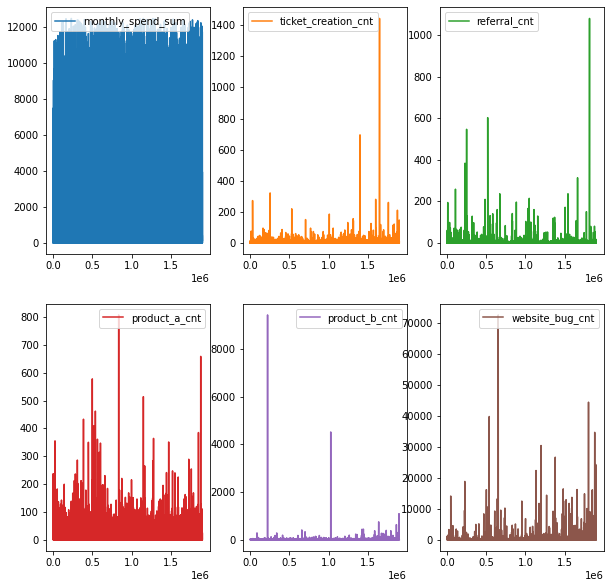

In [3]:
######################################################################################################################################################
##### EDA Part 1 #####
######################################################################################################################################################

# Aggregate mean metrics by uuid (user)
df_user = df.drop(['billing_segment_id'], axis=1)
df_user.groupby('uuid').agg(['mean'])

# Plot user level data
plt = df_user.plot(subplots=True, layout=(2, 3), figsize=(10, 10), sharex=False)

VIF


,variables,VIF
0,monthly_spend_sum,1.23
1,ticket_creation_cnt,1.01
2,referral_cnt,1.00
3,product_a_cnt,1.22
4,product_b_cnt,1.00
5,website_bug_cnt,1.00


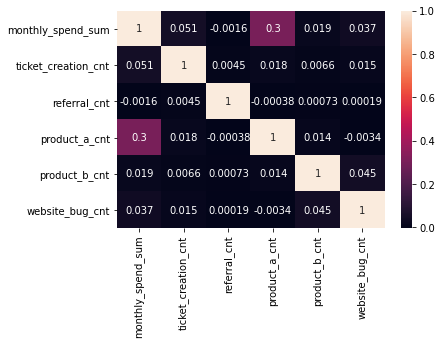

In [4]:
######################################################################################################################################################
##### EDA Part 2 #####
######################################################################################################################################################

# Set independent variables
X = df[['monthly_spend_sum','ticket_creation_cnt', 'referral_cnt','product_a_cnt','product_b_cnt','website_bug_cnt']] 

# Calculate correlation matrix
corr = X.corr()
sn.heatmap(corr, annot=True)

# Calculating variance inflation factor to check multicollinearity
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print ("VIF")
display (vif)

In [5]:
######################################################################################################################################################
##### Data Wrangling Part 1 #####
######################################################################################################################################################

######################################################################################################################################################
# Create quantitative variables
######################################################################################################################################################

# Create columns for min and max month
extra_vars = df.groupby('uuid').agg({'billing_segment_id': ['min', 'max']}) 
# Flatten column names
extra_vars.columns = ['_'.join(col).strip() for col in extra_vars.columns.values]

# Create column for user "tenure"
extra_vars['tenure'] = extra_vars['billing_segment_id_max'] - extra_vars['billing_segment_id_min']

# Get an idea of average user "tenure"
print ("Average Tenure")
print(extra_vars['tenure'].describe())
print('\n')

# Get distribution of months (suppress scientific notation)
print ("Billing Segment Id Distribution")
print (df['billing_segment_id'].describe().apply(lambda x: format(x, 'f')))
print('\n')

# Assign a churn flag
# If customer was NOT active in the last 2 months, we can assume they have "churned"
# Assume that the current month is 103, and anyone who does not have a record  prior to 102 is churned
extra_vars['churn'] = (np.where(extra_vars.billing_segment_id_max <= 102, 1, 0)) 

# Get an idea of churn vs active user ratio
print ("Churn vs Active Distribution")
print(extra_vars["churn"].value_counts())
print ("Percent of churned users")
print (sum(extra_vars["churn"])/len(extra_vars["churn"]))
print('\n')

# Join these user level variables back to the original data set
df_extended = pd.merge(left=df, right=extra_vars, how='left', left_on='uuid', right_on='uuid')

print (df_extended.head())

Average Tenure
count   118417.00
mean        15.57
std          7.82
min          0.00
25%          9.00
50%         18.00
75%         23.00
max        103.00
Name: tenure, dtype: float64


Billing Segment Id Distribution
count    1902105.000000
mean          92.248179
std            6.777716
min            0.000000
25%           87.000000
50%           93.000000
75%           98.000000
max          103.000000
Name: billing_segment_id, dtype: object


Churn vs Active Distribution
0    85438
1    32979
Name: churn, dtype: int64
Percent of churned users
0.27849886418335207


   monthly_spend_sum  ticket_creation_cnt  referral_cnt  product_a_cnt  \
0             808.87                 0.00          0.00           0.00   
1             584.00                 0.00          0.00           0.00   
2             831.12                 0.00          0.00           0.00   
3            1056.12                 0.00          0.00           0.00   
4               2.38                 0.00         

In [6]:
######################################################################################################################################################
##### Data Wrangling Part 3 #####
######################################################################################################################################################

# Aggregate data to the user level for model input
# While we can possibly work with time series data, it will be simpler if there was one input record per user

df_user_final = df_extended.groupby(['uuid', 'tenure', 'churn']).agg({'monthly_spend_sum': ['mean','sum'], 'ticket_creation_cnt': ['sum'], 
                                 'referral_cnt' : ['sum'], 'product_a_cnt' : ['sum'], 'product_b_cnt' : ['sum'],
                                 'website_bug_cnt' : ['sum'], 
                                 'billing_segment_id_max' : ['max']}) 

# Flatten column names
df_user_final.columns = ['_'.join(col).strip() for col in df_user_final.columns.values]
df_user_final.reset_index(inplace=True)

# Rename some columns so they are less confusing
# We only used the "max" function in the aggregation to get whether or not the value is 1 for each user
df_user_final.rename({"bug_on_churn_max": "bug_on_churn", "ticket_on_churn_max": "ticket_on_churn", "billing_segment_id_max_max" : "billing_segment_id_max"}, axis=1, inplace=True)

display (df_user_final.head())

,uuid,tenure,churn,monthly_spend_sum_mean,monthly_spend_sum_sum,ticket_creation_cnt_sum,referral_cnt_sum,product_a_cnt_sum,product_b_cnt_sum,website_bug_cnt_sum,billing_segment_id_max
0,00001694-c1f8-32aa-913f-561ceb080056,2.00,1,452.92,1358.75,2.00,0.00,0.00,3.00,5.00,101.00
1,0000fd28-5d97-3239-819d-7ca9c022b2bc,23.00,0,411.51,9876.12,1.00,0.00,0.00,0.00,23.00,103.00
2,000162d6-018c-3fa7-a0fb-fc75756fddaf,22.00,0,707.68,16276.75,2.00,0.00,132.00,2.00,2.00,103.00
3,00016f9d-5288-3820-960e-c1dc1100002f,10.00,0,219.34,2412.75,0.00,0.00,0.00,0.00,2.00,103.00
4,00021e21-42ea-301c-b07d-62c5b0224ebe,23.00,0,734.47,17627.38,0.00,0.00,19.00,23.00,63.00,103.00


In [7]:
######################################################################################################################################################
##### Standardize Data Set #####
######################################################################################################################################################

# Split final data set to dependent vs independent variables    
y = df_user_final['churn']
X = df_user_final.drop(['churn'], axis = 1)

# Standardize independent variables to reduce multicollinearity and so all variables contribute equally to the model
def standardize(df):
    scaler = StandardScaler()
    df2 = pd.DataFrame(scaler.fit_transform(df))
    df2.columns = df.columns.values
    df2.index = df.index.values
    return df2

# Standardize all except uuid
X_std = standardize(X.loc[:, X.columns != 'uuid'])

# Append uuid column back to standardized dataset
X_std['uuid'] = X['uuid']

######################################################################################################################################################
##### First pass: Simple 80/20 split of Data Set #####
######################################################################################################################################################

# Split data into train vs test (80% train, 20% test)
# Stratify based on response so that both sets contain similar ratio of churn vs active customers
X_train, X_test, y_train, y_test = train_test_split(X_std, y,stratify=y, test_size = 0.2, shuffle=True, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

display(X_train.head())
display(X_test.head())

Number transactions X_train dataset:  (94733, 10)
Number transactions y_train dataset:  (94733,)
Number transactions X_test dataset:  (23684, 10)
Number transactions y_test dataset:  (23684,)


,tenure,monthly_spend_sum_mean,monthly_spend_sum_sum,ticket_creation_cnt_sum,referral_cnt_sum,product_a_cnt_sum,product_b_cnt_sum,website_bug_cnt_sum,billing_segment_id_max,uuid
84544,0.95,0.93,1.33,-0.21,-0.03,-0.33,0.64,-0.02,0.48,b6d0def6-6338-3ad9-93b8-d0105d4ff590
65789,0.95,-0.19,0.03,-0.12,-0.03,-0.33,-0.05,-0.03,0.48,8e618075-8427-36c5-a684-bea8590e013b
38414,0.82,-0.12,0.09,-0.21,-0.03,0.32,-0.06,-0.03,0.29,53a7d1fd-61b4-3c4e-a674-ac324be000ec
39247,-0.20,-0.20,-0.21,0.15,-0.03,0.06,-0.06,-0.03,0.48,5563de93-73b4-34ed-b193-b68601a59f5c
12978,-0.33,1.87,1.16,-0.21,-0.03,2.69,0.00,-0.03,0.48,1c54080e-9e3f-3f4a-a379-e9f94311ba6d


,tenure,monthly_spend_sum_mean,monthly_spend_sum_sum,ticket_creation_cnt_sum,referral_cnt_sum,product_a_cnt_sum,product_b_cnt_sum,website_bug_cnt_sum,billing_segment_id_max,uuid
43485,0.95,-0.49,-0.31,-0.12,0.00,-0.33,-0.06,-0.03,0.48,5e808652-3c54-3763-b3e2-8c057a2f0bef
77899,0.95,2.02,2.59,0.15,-0.03,-0.15,0.04,0.02,0.48,a873e507-10c7-37cc-90dc-f729f42e3564
24117,0.95,1.09,1.51,0.42,-0.03,0.86,0.04,-0.03,0.48,3463e140-7d0f-37d6-8d78-75e34129b91a
1323,0.95,1.43,1.90,0.87,-0.03,-0.25,-0.06,-0.02,0.48,02d5c20f-9f15-3c7e-9751-f47c4ce05a18
15386,-1.35,-0.29,-0.47,0.06,-0.03,-0.33,-0.06,-0.03,-1.81,2193785e-0064-3e8e-b8c3-b44bdb80e41b


In [8]:
######################################################################################################################################################
##### Logistic Regression: Initial pass #####
######################################################################################################################################################

# Store X without uuid or the max billing month (exclude both as a feature in model)
X_train_no_uuid = X_train.drop(['uuid','billing_segment_id_max'], axis= 1)
X_test_no_uuid = X_test.drop(['uuid', 'billing_segment_id_max'], axis= 1)

# Instantiate model and train (exclude uuid column in model)
log_reg = LogisticRegression()
log_reg.fit(X_train_no_uuid, y_train)

print ('Logistic Regression: Model Coefficients')
display (pd.DataFrame(zip(X_train_no_uuid.columns, np.transpose(log_reg.coef_)), columns=['features', 'coef']))
print ('\n')

# Run model on entire test set
y_predict = log_reg.predict(X_test_no_uuid)

# Evaluate accuracy using score (what percentage of predictions were correct?)
print ('Accuracy Score')
print(metrics.accuracy_score(y_test, y_predict))
print ('\n')

# Evaluate via confusion matrix
cm = metrics.confusion_matrix(y_test, y_predict)
print ('Confusion Matrix')
print (cm)
print ('\n')

# Suppress scientific notation
np.set_printoptions(suppress=True)

# Get probability score of churn for X_test
y_pred_probs = log_reg.predict_proba(X_test_no_uuid)

y_pred_probs = y_pred_probs[:, 1] # we only care about the second column, which is probably of churn = 1

# Store the relevant columns in a final dataframe
final_results = pd.concat([X_test['uuid'], y_test], axis = 1,  names=['uuid', 'churn_actual'])

# Add the predictive columns
final_results['churn_predict'] = y_predict
final_results['churn_probability'] = y_pred_probs

# Merge in tenure years for the test user set
final_results = pd.merge(left=final_results, right=df_user_final[['uuid','tenure']], how='left', left_on='uuid', right_on='uuid')

print ('Final Prediction Results for X_test')
display (final_results.head())

print ('Average number of months in program, for users with 60%+ likelihood to churn')
print(final_results[final_results['churn_probability'] > .6]['tenure'].agg('mean'))

Logistic Regression: Model Coefficients


,features,coef
0,tenure,[-1.0696498536625132]
1,monthly_spend_sum_mean,[-0.00669835980735128]
2,monthly_spend_sum_sum,[-0.31428165729968477]
3,ticket_creation_cnt_sum,[0.004214148073390027]
4,referral_cnt_sum,[-0.05284841599100508]
5,product_a_cnt_sum,[-0.596878612262386]
6,product_b_cnt_sum,[-0.36073031937275163]
7,website_bug_cnt_sum,[0.0015966945262424893]




Accuracy Score
0.7687468333051849


Confusion Matrix
[[15004  2084]
 [ 3393  3203]]


Final Prediction Results for X_test


,uuid,churn,churn_predict,churn_probability,tenure
0,5e808652-3c54-3763-b3e2-8c057a2f0bef,0,0,0.12,23.00
1,a873e507-10c7-37cc-90dc-f729f42e3564,0,0,0.04,23.00
2,3463e140-7d0f-37d6-8d78-75e34129b91a,0,0,0.03,23.00
3,02d5c20f-9f15-3c7e-9751-f47c4ce05a18,0,0,0.06,23.00
4,2193785e-0064-3e8e-b8c3-b44bdb80e41b,1,1,0.62,5.00


Average number of months in program, for users with 60%+ likelihood to churn
2.623433242506812


In [9]:
######################################################################################################################################################
##### Logistic Regression: Cross Validation #####
######################################################################################################################################################

# Check if we are potentially overfitting our model.

# For cross validation we won't need uuid, billing segment
X_std_no_uuid = X_std.drop(['uuid','billing_segment_id_max'], axis= 1)

# Implementing stratified k fold cross validation (5 fold).
# Use stratified k-fold due to imbalance in churn vs active users
# Since we had sorted the data earlier, should apply shuffle so it is sorted before data is split
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0) 
acc_score = [] # this is an empty list to store the accuracy scores for each fold

fold_num = 0

print ('K-fold cross validation, k =',k)

for i , j in skf.split(X_std_no_uuid, y):
    # Track which "fold" we are at so it can be used to print metrics as we are validating data
    fold_num += 1  
    
    # Loop through each "fold", split data and train
    X_train , X_test = X_std_no_uuid.iloc[i,:],X_std_no_uuid.iloc[j,:]
    y_train , y_test = y[i] , y[j]
    
    # Check the ratio of data in each fold to ensure we have a reasonable churn to active user ratio
    print('Fold',str(fold_num), 'Class Ratio:', sum(y_test)/len(y_test))
     
    log_reg.fit(X_train,y_train)
    y_predict = log_reg.predict(X_test)
    
    # Store the accuracy score for each "fold" as an element in the list
    acc = metrics.accuracy_score(y_test, y_predict)
    acc_score.append(acc)

    print('Fold',str(fold_num), 'Accuracy:', acc)    
print ('\n')

# Get the average accuracy score across all the folds
avg_acc_score = sum(acc_score)/k
print ('Average kfold accuracy score')
print (avg_acc_score)

K-fold cross validation, k = 5
Fold 1 Class Ratio: 0.2785002533355852
Fold 1 Accuracy: 0.7708579631818949
Fold 2 Class Ratio: 0.2785002533355852
Fold 2 Accuracy: 0.7687468333051849
Fold 3 Class Ratio: 0.27851201283621163
Fold 3 Accuracy: 0.7651057720727948
Fold 4 Class Ratio: 0.27851201283621163
Fold 4 Accuracy: 0.7680614786978001
Fold 5 Class Ratio: 0.2784697884558544
Fold 5 Accuracy: 0.7698771270531605


Average kfold accuracy score
0.7685298348621671


In [10]:
######################################################################################################################################################
##### Churn Monetary Impact #####
######################################################################################################################################################

# Calculate average tenure of churned users
df_churned = df_user_final[df_user_final['churn'] == 1]
avg_tenure = df_churned['tenure'].agg('mean')
print ("Average Tenure:",str(avg_tenure))

# Get number of total users by month
total_monthly_users = df_extended.groupby('billing_segment_id').agg({'uuid' : ['nunique']})
total_monthly_users.columns = ['_'.join(col).strip() for col in total_monthly_users.columns.values]
total_monthly_users.reset_index(inplace=True)
total_monthly_users.columns = ['billing_segment_id', 'num_uniq_users']

# Aggregate the sum of the average user monthly spend by the month the user churned (i.e. their last month of activity)
monthly_churn = (df_churned.groupby('billing_segment_id_max').agg({'monthly_spend_sum_mean': ['mean', 'count'], 'tenure' : ['mean']}))

monthly_churn.columns = ['_'.join(col).strip() for col in monthly_churn.columns.values]
monthly_churn.reset_index(inplace=True)
monthly_churn.columns = ['billing_segment_id', 'monthly_avg_user_spend', 'num_users_churned', 'avg_tenure']

# Exclude the current month since these users are still considered active
monthly_churn = monthly_churn[monthly_churn['billing_segment_id']< 103]

# Calculate avg monthly spend of churned users
avg_monthly_spend = df_churned['monthly_spend_sum_mean'].agg('mean')
print ("Average Monthly Spend:",str(avg_monthly_spend))

# Average user tenure is 15.69 months, and average monthly spend is 617.55
average_cltv = avg_tenure * avg_monthly_spend
print ("Average CLTV:",str(average_cltv))

# Merge in the num_uniq_users col to calculate monthly churn rate
monthly_churn = pd.merge(left=monthly_churn, right=total_monthly_users, how='left', left_on='billing_segment_id', right_on='billing_segment_id')
monthly_churn['churn_rate'] = monthly_churn['num_users_churned']/monthly_churn['num_uniq_users']
monthly_churn['monthly_spend_loss_to_churn'] = monthly_churn['num_users_churned']*monthly_churn['monthly_avg_user_spend']

# Calculate average month over month change in active users
monthly_churn['program_growth_rate'] = monthly_churn['num_uniq_users'].pct_change()

avg_monthly_growth = monthly_churn['program_growth_rate'].agg('mean')
print ("Average Program Growth Rate:",str(avg_monthly_growth))

display(monthly_churn)

Average Tenure: 9.208344704205707
Average Monthly Spend: 504.7559191349828
Average CLTV: 4647.966494883103
Average Program Growth Rate: 0.01718044356949009


,billing_segment_id,monthly_avg_user_spend,num_users_churned,avg_tenure,num_uniq_users,churn_rate,monthly_spend_loss_to_churn,program_growth_rate
0,80.00,310.27,415,0.00,60641,0.01,128763.25,NaN
1,81.00,530.40,949,0.97,63409,0.01,503347.75,0.05
2,82.00,577.04,735,1.76,65225,0.01,424122.17,0.03
3,83.00,607.15,722,2.56,67130,0.01,438365.83,0.03
4,84.00,590.13,792,3.30,68968,0.01,467386.20,0.03
5,85.00,561.78,896,4.05,70960,0.01,503356.66,0.03
6,86.00,554.25,995,4.65,72791,0.01,551481.31,0.03
7,87.00,566.90,990,5.43,74523,0.01,561235.82,0.02
8,88.00,532.52,716,6.30,76438,0.01,381284.80,0.03
9,89.00,534.46,1081,6.54,78325,0.01,577755.67,0.02
